## Objective

The objective of this project is to develop a deep learning model that can detect whether a person is wearing a mask, not wearing a mask or incorrectly wearing a mask. This first requires a model to detect a face, then a model to classify if a mask is worn correctly.

## Imports

In [45]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import os
import cv2
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
import shutil

## Helpers

In [2]:
def parse_xml(filename):
    dirname = os.path.abspath('')
    absolute_path = os.path.join(dirname, filename)
    tree = ET.parse(absolute_path)
    root = tree.getroot()

    height = int(root.find('size').findtext('height'))
    width = int(root.find('size').findtext('width'))
    name = root.findtext('filename') # need this?
    boxes = []

    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.findtext('xmin'))
        ymin = int(bndbox.findtext('ymin'))
        xmax = int(bndbox.findtext('xmax'))
        ymax = int(bndbox.findtext('ymax'))
        mask = obj.findtext('name')
        boxes.append([mask, xmin, ymin, xmax, ymax])

    return boxes, (height, width), name

In [3]:
cmap = {
    'without_mask': (255, 0, 0),
    'with_mask': (0, 255, 0),
    'mask_weared_incorrect': (255, 255, 0)
}

def view_annotations(filename):
    dirname = os.path.abspath('')
    absolute_path = os.path.join(dirname, filename)
    bgr_img = cv2.imread(absolute_path)
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    
    img_path = 'datasets/facemask/annotations/' + filename.split('/')[3][:-3] + 'xml'
    annotations, _, _ = parse_xml(img_path)
    for annot in annotations:
        start_point = (annot[1], annot[2])
        end_point = (annot[3], annot[4])
        mask_status = annot[0]
        color = cmap[mask_status]
        cv2.rectangle(rgb_img, start_point, end_point, color, 2)
        cv2.putText(rgb_img, mask_status, (annot[1] - 20, annot[2] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.66, color, 1, cv2.LINE_AA)
    plt.imshow(rgb_img)

## Visualization

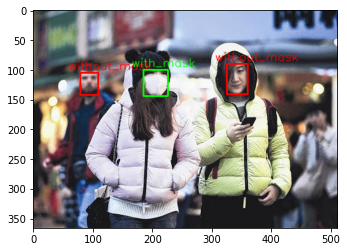

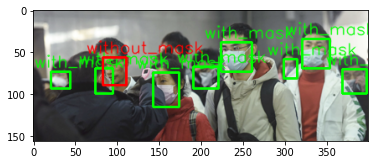

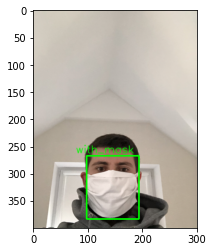

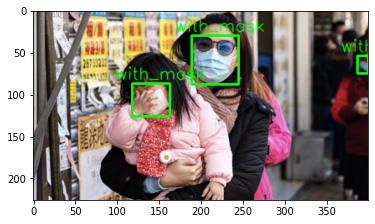

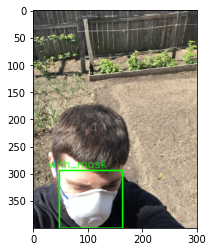

In [39]:
images = ['datasets/facemask/images/' + fp for fp in os.listdir('datasets/facemask/images')]
annotations = ['datasets/facemask/annotations/' + fp for fp in os.listdir('datasets/facemask/annotations')]

for i in range(5):
    plt.figure()
    view_annotations(images[i])

plt.show()

In [5]:
freq_dict = {}
for i, annot in enumerate(annotations):
    bndbox, _, _ = parse_xml(annot)
    for box in bndbox:
        if box[0] not in freq_dict:
            freq_dict[box[0]] = 1
        else:
            freq_dict[box[0]] += 1
x = list(freq_dict.keys())
y = list(freq_dict.values())
percents = [count / sum(y) for count in y]
plot_text = [str(count) + ' (' + str(round(percent, 2)) + ')' for (count, percent) in zip(y, percents)]
freq_plot = go.Figure([go.Bar(x=x, y=percents, text=plot_text)])
freq_plot.update_layout(
    title_text='Mask Wear Frequency',
    title_x=0.5,
    xaxis_title='Mask Wear',
    yaxis_title='Percentage',
)
freq_plot.show()

## Prepare the Data

We now create a directory under the facemask folder containing these labels and create a text file of annotations in the Yolov5 format for every image. 

In [15]:
# code to create a directory under the facemask folder in yolov5 format
# [class] [x_center] [y_center] [width] [height]
try:
    os.mkdir('datasets/facemask/labels')
except OSError as error:
    print(error)

[WinError 183] Cannot create a file when that file already exists: 'datasets/facemask/labels'


Now, we must convert the annotation data into a Yolov5 format. There should be a text file for every single image where the text file has an annotation for each bounding box in the image. Each line should be as follows:

[class] [x_center] [y_center] [width] [height]

Furthermore, the top left of the image is considered to be (0, 0) while the bottom right of the image is (1, 1).

In [32]:
def convert_to_yolov5_format(bndbox, dim):
    name, xmin, ymin, xmax, ymax = bndbox
    height, width = dim
    x_center = ((xmin + xmax) / 2) / width
    y_center = ((ymin + ymax) / 2) / height
    normalized_width = (xmax - xmin) / width
    normalized_height = (ymax - ymin) / height
    return name, x_center, y_center, normalized_width, normalized_height

In [33]:
names = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2
}

for annot in annotations:
    
    bndbox, dim, fname = parse_xml(annot)
    if len(bndbox) == 0:
        continue
    
    fpath = 'datasets/facemask/labels/' + fname[:-3] + 'txt'
    
    with open(fpath, 'w') as f:
        for box in bndbox:
            name, x_center, y_center, width, height = convert_to_yolov5_format(box, dim)
            f.writelines(f'{name} {x_center} {y_center} {width} {height}\n')

Now, we must move data into the train, validation and test sets.

In [42]:
labels = ['datasets/facemask/labels/' + fp for fp in os.listdir('datasets/facemask/labels')]

images.sort()
labels.sort()

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(val_images, val_labels, test_size=0.5, random_state=42)

Create additional directories in accordance to the yaml configuration file and insert the partitioned data.

In [53]:
dirs = ['datasets/facemask/images/train', 'datasets/facemask/images/val', 'datasets/facemask/images/test', \
        'datasets/facemask/labels/train', 'datasets/facemask/labels/val', 'datasets/facemask/labels/test']
for d in dirs:
    try:
        os.mkdir(d)
    except OSError as error:
        print(error)

def move_files(lof, dest):
    try:
        for file in lof:
            shutil.move(file, dest)
    except shutil.Error as e:
        print('Please check that the files and destination folders are correct.')
        
move_files(train_images, 'datasets/facemask/images/train')
move_files(val_images, 'datasets/facemask/images/val')
move_files(test_images, 'datasets/facemask/images/test')
move_files(train_labels, 'datasets/facemask/labels/train')
move_files(val_labels, 'datasets/facemask/labels/val')
move_files(test_labels, 'datasets/facemask/labels/test')

[WinError 183] Cannot create a file when that file already exists: 'datasets/facemask/images/train'
[WinError 183] Cannot create a file when that file already exists: 'datasets/facemask/images/val'
[WinError 183] Cannot create a file when that file already exists: 'datasets/facemask/images/test'
[WinError 183] Cannot create a file when that file already exists: 'datasets/facemask/labels/train'
[WinError 183] Cannot create a file when that file already exists: 'datasets/facemask/labels/val'
[WinError 183] Cannot create a file when that file already exists: 'datasets/facemask/labels/test'
Please check that the files and destination folders are correct.
Please check that the files and destination folders are correct.
Please check that the files and destination folders are correct.
Please check that the files and destination folders are correct.
Please check that the files and destination folders are correct.
Please check that the files and destination folders are correct.


### TODO: k-fold cross validation

## Model Training

In [54]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=False)

Using cache found in C:\Users\Kai/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2021-12-29 torch 1.10.1+cu113 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]

In [ ]:
batch_size = 64
epochs = 32
learning_rate = 0.01
device = '0' if torch.cuda.is_available() else 'cpu'

!cd yolov5
!python train.py --img 640 --batch batch_size --epochs epochs --data data/facemask.yaml 

## Hyperparameters